# Intro to PyTorch

## 2. Pytorch Workflows

Based on Bourkes's https://www.learnpytorch.io/


Here's a standard PyTorch workflow.

![](./01_a_pytorch_workflow.png)

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

## 2.1. Prepare the data

Here we will generate our own data, a straight line, then use PyTorch to find the slope (weight) and intercept (bias).


In [7]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end   = 1
step  = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Train, validate, test split

- training set -> model learns from this data
- validation ste -> model is tuned on this data
- test set -> model is evluated on this data

In [8]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test,  y_test  = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Create a function to visualize the data.

In [22]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
      """
      Plots training data, test data and compares predictions.
      """
      plt.figure(figsize=(10, 7))

      # Plot training data in blue
      plt.scatter(train_data, train_labels, c="b", s=20, label="Training data")

      # Plot test data in green
      plt.scatter(test_data, test_labels, c="orange", s=20, label="Testing data")

      if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

      # Show the legend
      plt.legend(prop={"size": 14});

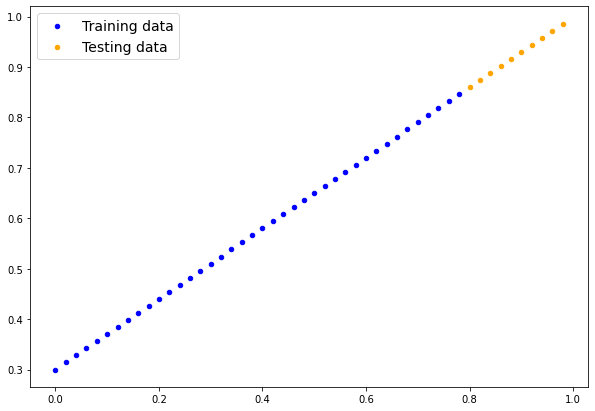

In [23]:
plot_predictions()

## 2.2 Build the model

There are 4 essential modules for creating any NN

- `torch.nn` contains all the building blocks of the computational graph
- `torch.optim` contains the different optimization algorithms
- `torch.utils.data.Dataset` selects data
- `torch.utils.data.DataLoader` loads the data

The NN itself, defined by `torch.nn`, contains the following sub-modules

- `nn.Module` has the layers
- `nn.Parameter` has the weights and biases

Finally, all the `nn.Module` subclasses require a `forward()` method that defines the flow of the computation, or structure of the NN.

We create a standard *linear regression* class.

In [2]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                    dtype=torch.float), # <- PyTorch uses float32 by default
                                    requires_grad=True) # <- update this value with gradient descent

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                dtype=torch.float), # <- PyTorch uses float32 by default
                                requires_grad=True) # <- update this value with gradient descent

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Now, let's create an instance of the model and check its prameters.

In [3]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model 
# (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can retrieve the state of the model, with `.stat_dict()`

In [18]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Make predictions with `torch.inference_mode()`

Before optimizing, we can already make (bad) predictions with this randomly initialized model. We will use the `torch.inference_mode()` function that streamlines the inference process.

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


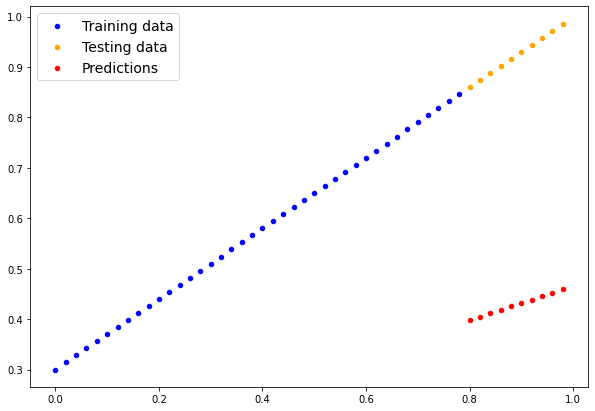

In [24]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

plot_predictions(predictions=y_preds)

These predicitions are way off, as expected, since they are based on a random initialization. Let us compute the errors.

In [25]:
# errors
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## Train the model

We need to define

- a loss function
- an optimizer

Here we will use

- MAE `torch.nn.L1Loss()`
- SGD `torch.optim.SGD(params, lr)`

  - `params` are the model parameters that we want to adjust optimally
  - `lr` is the learning rate (step-size) of the gradient descent, a *hyperparameter*

.

In [4]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate 
                                     # (how much the optimizer should change parameters at each 
                                     # step, higher=more (less stable), lower=less (might take a long time))

Finally, we need the training and testing loops.

### Training loop

![](./01-pytorch-training-loop-annotated.png)

Here are the 5 basic steps:

1. forward pass through the training data -> `model(x_train)`
2. compute the loss -> `loss=loss_fn(y_pred,y_train)`
3. set gradients to zero -> `optimizer.zero_grad()`
4. do backprop on the loss to compute gradient -> `loss.backward()`
5. update the parametes with the gradient -> `optimizer.step()` 


### Testing loop

![](./01-pytorch-testing-loop-annotated.png)

In 3 steps:

1. forward pass ->  `model(x_test)`
2. compute the loss -> `loss=loss_fn(y_pred,y_test)`
3. compute evaluation metrics/scores


We put it all together, and train for 1000 epochs of the SGD.

In [9]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Advance the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening every 10 steps
      if epoch % 20 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 


Finally, plot the loss curves.

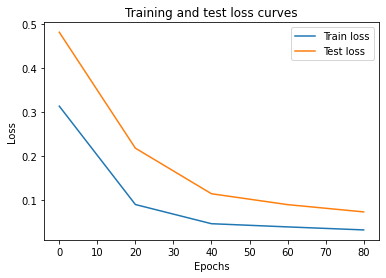

In [10]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Now, inspect the model's `state_dict()` to see how close we got.

In [32]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nThe original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Use trained model for predictions

To do inference with a PyTorch model:

1. Set model in evaluation mode -> `model.eval()`
2. Make predictions using the inference mode context manager -> `with torch.inference_mode()`
3. All predictions should be on objects on the same device - GPU/CPU

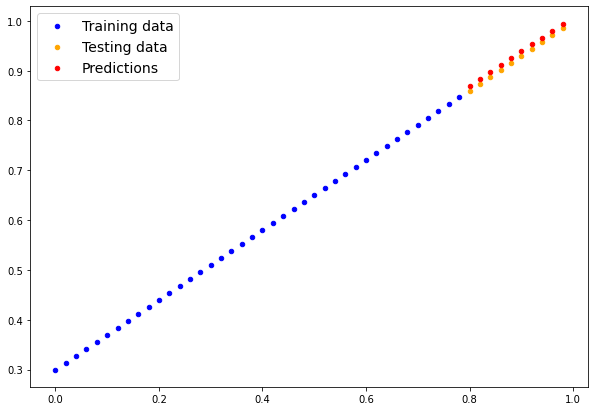

In [33]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

# plot the result
plot_predictions(predictions=y_preds)

Final error plot, showing noise "ball" limit.

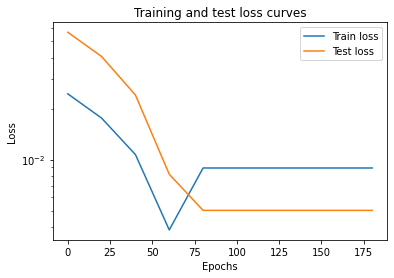

In [34]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving and loading trained models

Three main methods:

- `torch.save` uses `pickle` to save anything
- `torch.load` unpickles 
- `torch.nn.Module.load_state_dict` loads a model's parameter dictionary (`model_save_dict()`)

In [41]:
from pathlib import Path

# 1. Create 'models' directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


In [42]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r--@ 1 markasch  staff  1207 Feb 14 14:15 models/01_pytorch_workflow_model_0.pth


### Load a saved model

We have saved the model's state dictionary at a given path. We can now load it using

> `torch.nn.Module.load_state_dict(torch.load(f=)) ` 

To test this, we create anew instance of the `LinearRegressionModel()`, which being a subclass of `torch.nn.Module` has all its built-in methods, and in particular `load_state_dict()`.

In [43]:
# Instantiate a new instance of our model (this will be instantiated 
# with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new 
# instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Now, we are ready to perform inference.

In [44]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model
    
# Compare previous model predictions with loaded model predictions 
# (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Device Agnostic Version of pyTorch ML Workflow

Using all the above snippets, we can now write a complete, device agnostic workflow.

In [45]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

In [49]:
# Setup device agnostic code
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [50]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [51]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

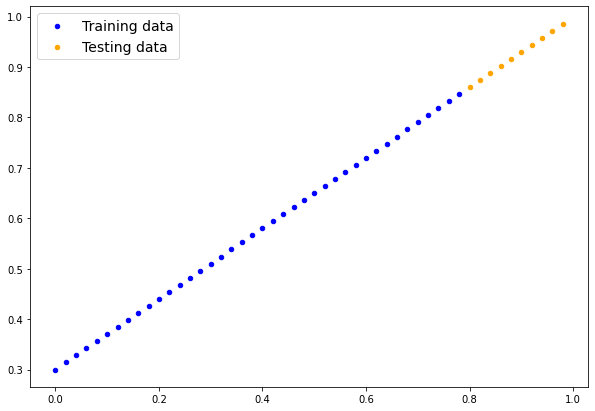

In [52]:
plot_predictions(X_train, y_train, X_test, y_test)

### Build the pyTorch Linear Model

Instead of manually defining weight and bias parmeters by "hand", using `nn.Parameter()`, we will use e pre-built `torch.nn` module,

> `nn.Linear(dim_in_features, dim_out_features)`

![](./01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)


In [53]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need 
# but is used for demonstrative purposes, try commenting it out and 
# seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Now, we can place the model onto the gpu device (after checking)

In [54]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [55]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda"/"mps" 
                   # if available or "cpu" if not
next(model_1.parameters()).device

device(type='mps', index=0)

### Training

We use the same functions and hyperparameters as before

- `nn.L1Loss()`
- `torch.optim.SGD()`

In [56]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

Before training on the gpu, we must place the data there too.

In [57]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

/Users/markasch/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | Train loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch: 100 | Train loss: 0.0062156799249351025 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904


In [58]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Predictions

Use inference mode.

In [59]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

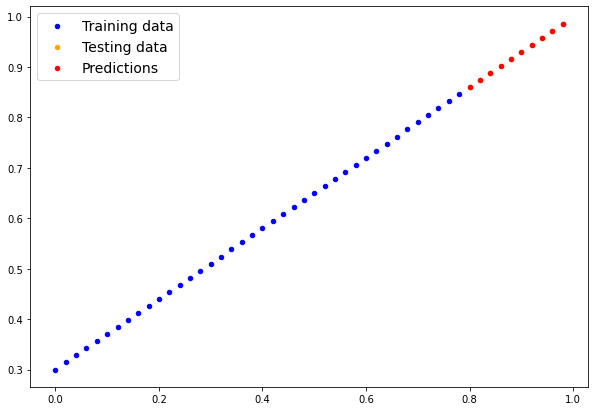

In [60]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

## Save and Load

Finally, save, load and perform inference.

In [61]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [62]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


In [63]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')

## To go further...

A more complete tutorial on `torch.nn` is available on the official pytorch website

> https://pytorch.org/tutorials/beginner/nn_tutorial.html